# Quick Start

We presently run through a simple example of how `kulprit` provides a simple and effective model selection procedure in the case of linear regression.

To begin with, we import the necessary dependencies for the initial model fitting (for which we use `bambi`) and data handling. The `kulprit` package provides all the machinery for model selection once we have fitted a `bambi` model.

In [1]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

## Data

To illustrate the use of `kulprit`, we begin with a linear regression with synthetic data.

In [2]:
# define the data
RANDOM_SEED = 453
np.random.seed(RANDOM_SEED)
x1 = np.random.normal(0, 0.5, 121)
x2 = np.random.normal(0, 1, 121)
y = np.random.normal(2 * x1 + 3, 0.25)
data = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

## The model

We presently look to fit a linear regression to these data, namely the model 

$$
y \sim \mathcal{N} (\beta_0 + \beta_1 x_1 + \beta_2 x_2, \sigma)
$$

with $\sigma>0$ and $\beta_i \in \mathbb{R}$, in which we treat $y$ as our variate, and $x_1$ and $x_2$ as the covariates. This is cleanly communicated to `bambi` in the following formula, and we fit the model with Markov Chain Monte Carlo (MCMC) methods. We will use the default `bambi` priors over $\beta_i$ and $\sigma$, on which more information can be found in [the `bambi` docs](https://bambinos.github.io/bambi/main/index.html).

In [3]:
# fit the reference model
model = bmb.Model("y ~ x1 + x2", data)
idata = model.fit(random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x1, x2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## Projection predictive model selection

We now perform the model selection procedure provided by `kulprit`. Our linear regression model is considered as the _reference model_, and we look to identify subsets of its parameters that achieve similar predictive performance. To begin with, let us instanciate `ProjectionPredictive` class.

In [4]:
ppi = kpt.ProjectionPredictive(model, idata)

Then we create the submodels, starting with an intercept-only model and keep adding variables, once at a time until we have added all. 

At each step, we "project" the reference model onto a given subset of parameters, and evaluate the predictive performance of this submodel. By projection, we concretely mean that for a reference model posterior $p(\boldsymbol y \mid \boldsymbol \beta^\ast)$ with $\boldsymbol \beta^\ast = (\beta_0, \beta_1, \beta_2)^T$, and a parameter subset $\boldsymbol \beta^\perp \subset \boldsymbol \beta^\ast$, we find the parameter values of $\boldsymbol \beta^\perp$ according to the solution to the optimisation problem
$$
\boldsymbol\beta^\perp = \arg\min_{\boldsymbol\beta} d \left( p(\boldsymbol y\mid \boldsymbol\beta),\, p(\boldsymbol y\mid \boldsymbol\beta^\ast) \right).
$$

In this formulation, $d(\cdot, \cdot)$ is the Kullback-Leibler distance metric. In a word, we look to achieve the values of $\boldsymbol \beta^\perp$ such that the posterior of their associated model is most close to the reference model. 

In [5]:
# perform the search procedure
ppi.search()

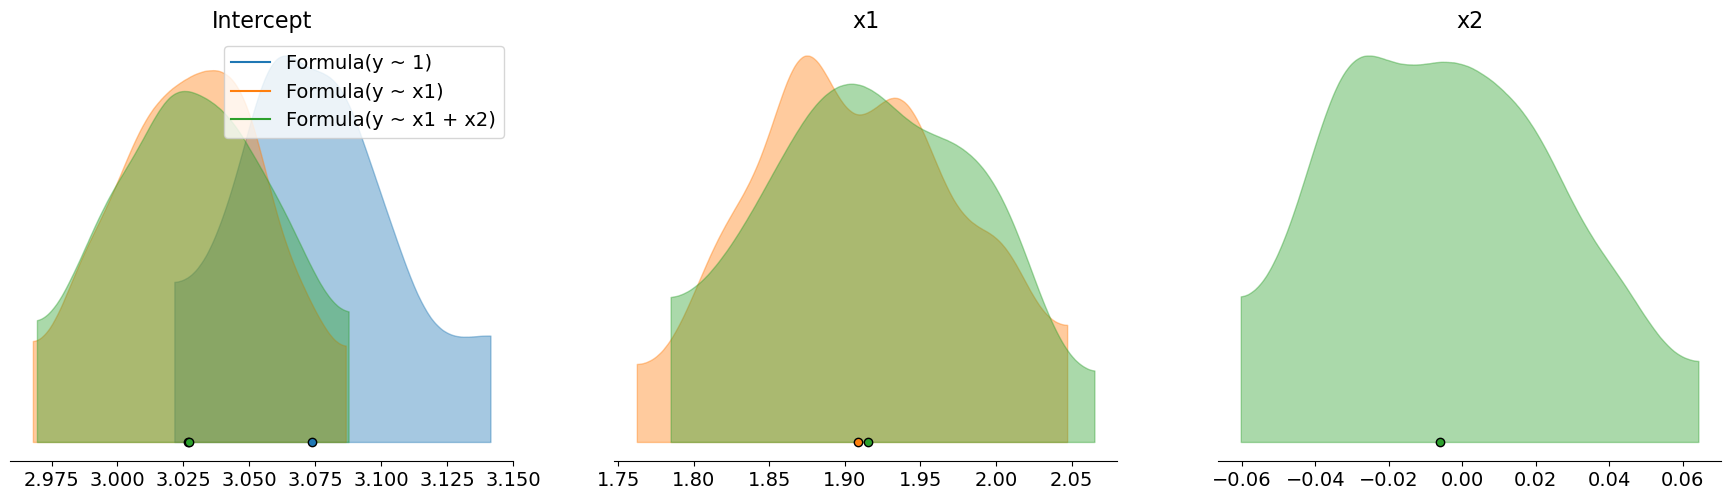

In [6]:
# compare the projected posterior densities of the submodels
ax = ppi.plot_densities();

Having performed the search, we have effectively generated a set of submodels according to a reference model. We find that the submodels generated increase in distance from the reference model with fewer number of parameters, as expected. It is now of interest to us to identify the one most closely resembling the reference model with the fewest parameters for parsimony. Given our focus on predictive performance, we do so by critiquing each of the submodels by their expected log-posterior density (ELPD) using leave-one-out cross-validation (LOO-CV). `kulprit` provides these tabular and graphic results easily with the `loo_compare` method.

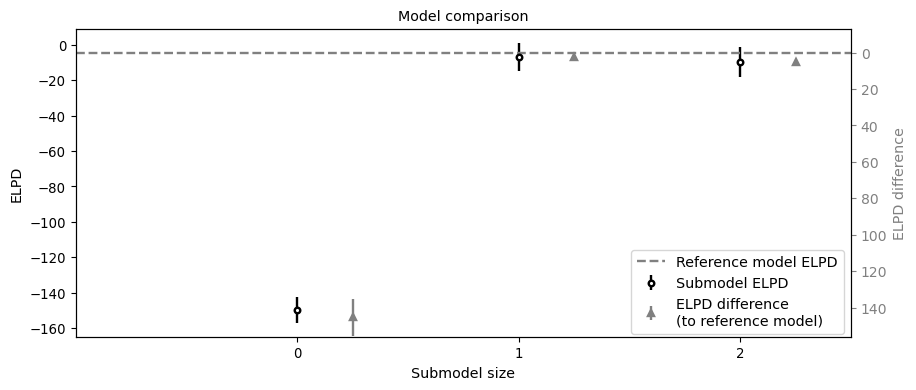

In [7]:
# compare submodels found in the search by LOO-CV ELPD
cmp, ax = ppi.plot_compare(plot=True, figsize=(10, 4));

From these results we can see that the difference between the reference model and the model with only one parameter is very small. Thus we may want to keep this smaller model. In the following cell we can see that the model is `y ~ x1`.

In [8]:
ppi

  0 y ~ 1
  1 y ~ x1
  2 y ~ x1 + x2

We can obtain the submodel by specifying its size.

In [9]:
# project the reference model onto a chosen submodel size
submodel = ppi.project(1)
submodel

y ~ x1

Having achieved this submodel, we can more closely investigate the posterior distributions of its parameters alongside those of the reference mode model with `ArviZ`.

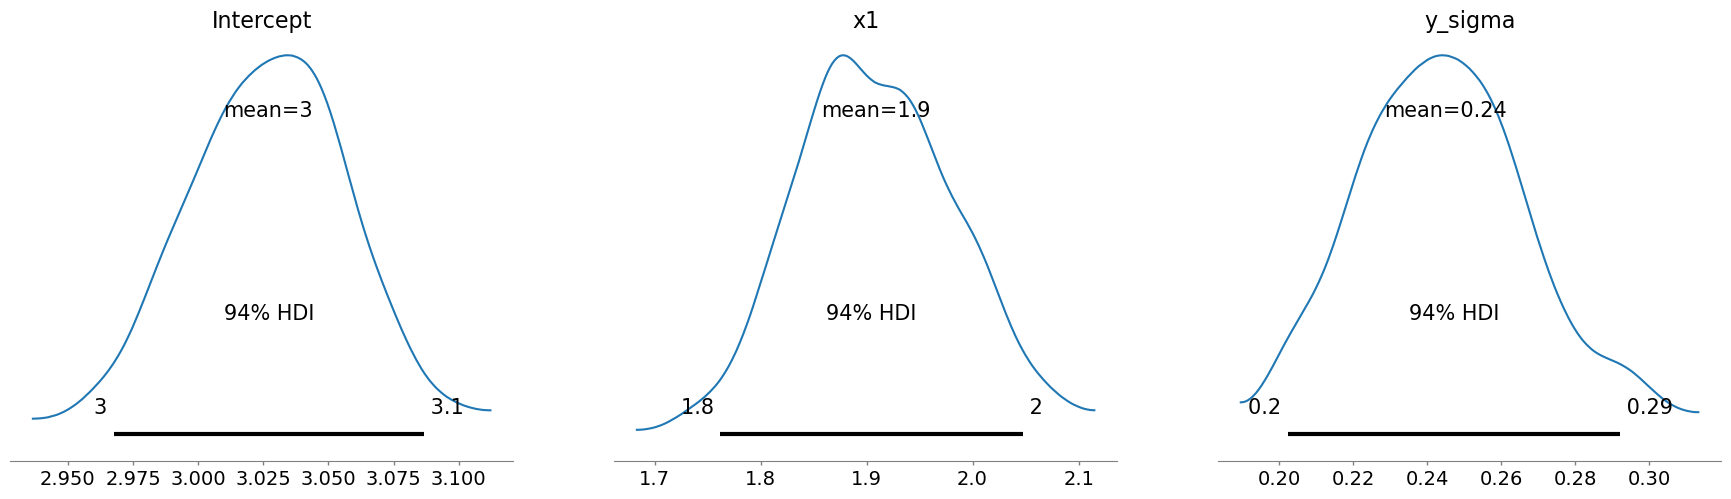

In [10]:
# visualize projected parameters
ax = az.plot_posterior(submodel.idata);